<a href="https://colab.research.google.com/github/TonyCardiff/29P/blob/main/29P_Rotational_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
#Import files except for 2015, use pattern recognition to pull date/magnitude/filter data

import re

input_files = [
    "/content/29P_2016.txt",
    "/content/29P_2017.txt",
    "/content/29P_2018-19.txt",
    "/content/29P_2019-20.txt",
    "/content/29P_2020-21.txt",
    "/content/29P_2021-22.txt",
    "/content/29P_2022-23.txt",
    "/content/29P_2023-24.txt",
    "/content/29P_2024-25.txt"
]
output_file = "/content/29P_Date_Magnitude.txt"

# Initialize a list to store all processed data and a log dictionary
all_data = []
file_log = {}

# Pattern to match date and magnitude
pattern_date = re.compile(r"(\d{4})\s(\d{2})\s(\d{1,2}\.\d+)")
pattern_mag = re.compile(r"(\d{2}\.\d{1,2}[A-Za-z])")

# Process each file
for file_path in input_files:
    with open(file_path, "r") as file:
        lines = file.readlines()

    original_line_count = len(lines)
    processed_line_count = 0

    for line in lines:
        # Search for date and magnitude in the line
        date_match = pattern_date.search(line)
        mag_match = pattern_mag.search(line)

        if date_match and mag_match:
            year, month, day = date_match.groups()
            day_decimal = round(float(day), 5)
            date = f"{year} {month} {day_decimal:08.5f}"
            magnitude = mag_match.group(1)

            all_data.append([date, magnitude])
            processed_line_count += 1

    # Store log information
    file_log[file_path] = {
        "Original lines": original_line_count,
        "Processed lines": processed_line_count
    }

# Save results to output file
with open(output_file, "w") as out_file:
    out_file.write("Date\tMagnitude\n")
    for entry in all_data:
        out_file.write("\t".join(entry) + "\n")

# Print summary of each file's processing
print(f"Processing complete. Results saved to: {output_file}")
for file, stats in file_log.items():
    print(f"{file}: {stats['Original lines']} lines read, {stats['Processed lines']} lines processed.")


Processing complete. Results saved to: /content/29P_Date_Magnitude.txt
/content/29P_2016.txt: 4060 lines read, 2726 lines processed.
/content/29P_2017.txt: 2035 lines read, 2003 lines processed.
/content/29P_2018-19.txt: 1027 lines read, 940 lines processed.
/content/29P_2019-20.txt: 3994 lines read, 2709 lines processed.
/content/29P_2020-21.txt: 5912 lines read, 4672 lines processed.
/content/29P_2021-22.txt: 5724 lines read, 4644 lines processed.
/content/29P_2022-23.txt: 5653 lines read, 4457 lines processed.
/content/29P_2023-24.txt: 5569 lines read, 4383 lines processed.
/content/29P_2024-25.txt: 3256 lines read, 2595 lines processed.


In [7]:
#Import created file and 2015 data, convert created file to julian date format and organise by year/jd, extract filter from magnitude column

import pandas as pd
from astropy.time import Time

input_file = "/content/29P_Date_Magnitude.txt"
input_file_2015 = "/content/29P_2015.txt"
output_file = "/content/29P_Julian_Magnitude_Filter.txt"

# Load the main data into a DataFrame
df = pd.read_csv(input_file, sep="\t")

# Convert Date to Julian Date
def to_julian(date_str):
    date_parts = date_str.split()
    year, month, day_decimal = date_parts

    # Convert day_decimal to integer day and fraction
    day_int = int(float(day_decimal))
    day_fraction = float(day_decimal) - day_int

    # Convert day_fraction to hours and minutes (ignore seconds)
    total_minutes = int(day_fraction * 1440)  # 24 hours * 60 minutes
    hours = total_minutes // 60
    minutes = total_minutes % 60

    # Construct ISO date-time string in 'YYYY-MM-DD HH:MM' format
    date_iso = f"{year}-{month}-{day_int:02d} {hours:02d}:{minutes:02d}"

    # Convert to Julian Date
    t = Time(date_iso, format='iso', scale='utc')
    return round(t.jd, 5)

# Apply conversion to Julian Date
df['Julian Date'] = df['Date'].apply(to_julian)

# Separate Magnitude and Filter
df['Filter'] = df['Magnitude'].str[-1]      # last character
df['Magnitude'] = df['Magnitude'].str[:-1]  # all but last character

# Extract Year from Date
df['Year'] = df['Date'].str.split().str[0]

# Select and reorder columns for output
df_final = df[['Year', 'Julian Date', 'Magnitude', 'Filter']]

# Load and process the 2015 data
df_2015 = pd.read_csv(input_file_2015, sep="\t", header=None, usecols=[4, 5], names=['Julian Date', 'Magnitude'])
df_2015['Year'] = 2015
df_2015['Filter'] = ''

# Append 2015 data to main DataFrame
df_final = pd.concat([df_final, df_2015[['Year', 'Julian Date', 'Magnitude', 'Filter']]])

# Sort data by Year and Julian Date
df_final = df_final.sort_values(by=['Year', 'Julian Date'])

# Save to output file
df_final.to_csv(output_file, sep='\t', index=False)

# Count entries
input_count = len(df) + len(df_2015)
output_count = len(df_final)

print(f"Processing complete. Output file saved to: {output_file}")
print(f"Input entries: {input_count}")
print(f"Output entries: {output_count}")

# Print unique filter values
unique_filters = df_final['Filter'].unique()
print("Unique filter values found:", unique_filters)



Processing complete. Output file saved to: /content/29P_Julian_Magnitude_Filter.txt
Input entries: 29785
Output entries: 29785
Unique filter values found: ['' 'N' 'R' 'C' 'V' 'B' 'T' 'r' 'G' 'o' 'I' 'c' 'd']


In [8]:
import pandas as pd

# Define file paths
input_file = "/content/29P_Julian_Magnitude_Filter.txt"
output_file = "/content/29P_R.txt"

# Load the data
try:
    df = pd.read_csv(input_file, sep="\t")

    # Filter the data where Filter column is 'R'
    df_filtered = df[df['Filter'] == 'R']

    # Extract the required columns
    df_filtered = df_filtered[['Year', 'Julian Date', 'Magnitude']]

    # Save to output file
    df_filtered.to_csv(output_file, sep="\t", index=False)

    # Print the number of lines extracted
    print(f"Extracted {len(df_filtered)} lines where Filter = R. Output saved to {output_file}")

except FileNotFoundError:
    print(f"Error: The file {input_file} was not found.")
except Exception as e:
    print(f"An error occurred: {e}")


Extracted 21679 lines where Filter = R. Output saved to /content/29P_R.txt


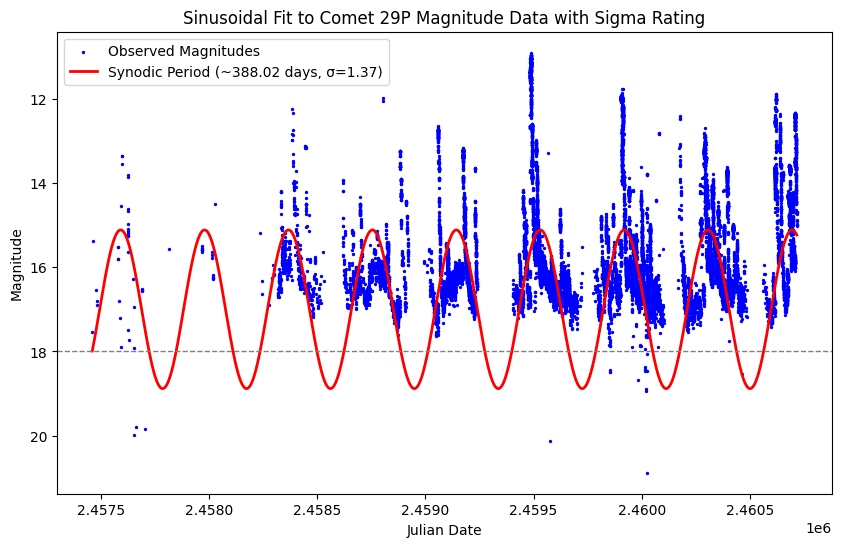

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Load the data from the file
file_path = "/content/29P_R.txt"
data = pd.read_csv(file_path, sep="\t")

# Extract relevant columns
julian_dates = data["Julian Date"].values
magnitudes = data["Magnitude"].values

# Remove NaNs and infinite values
mask = ~np.isnan(julian_dates) & ~np.isnan(magnitudes) & ~np.isinf(julian_dates) & ~np.isinf(magnitudes)
julian_dates, magnitudes = julian_dates[mask], magnitudes[mask]

# Define the refined sinusoidal function
def refined_sinusoidal(x, amplitude, phase, offset, period):
    frequency = 1 / period
    return amplitude * np.sin(2 * np.pi * frequency * x + phase) + offset

# Initial guess and bounds
initial_guess_synodic = [0.5, np.pi, 18, 388]
bounds = ([0, -2*np.pi, 17, 370], [5, 2*np.pi, 19, 410])

# Fit the sinusoidal model
try:
    popt_synodic, _ = curve_fit(refined_sinusoidal, julian_dates, magnitudes,
                                p0=initial_guess_synodic, bounds=bounds, maxfev=10000)

    # Generate smooth curve for fitted model
    smooth_julian_dates = np.linspace(min(julian_dates), max(julian_dates), 5000)
    smooth_fitted_synodic = refined_sinusoidal(smooth_julian_dates, *popt_synodic)

    # Calculate residuals
    residuals_synodic = magnitudes - refined_sinusoidal(julian_dates, *popt_synodic)
    sigma_synodic = np.std(residuals_synodic)

    # Plot results
    plt.figure(figsize=(10, 6))
    plt.scatter(julian_dates, magnitudes, s=2, color="blue", label="Observed Magnitudes")
    plt.plot(smooth_julian_dates, smooth_fitted_synodic, color="red", label=f"Synodic Period (~{popt_synodic[3]:.2f} days, σ={sigma_synodic:.2f})", linewidth=2)

    plt.axhline(y=18, color="gray", linestyle="--", linewidth=1)
    plt.xlabel("Julian Date")
    plt.ylabel("Magnitude")
    plt.title("Sinusoidal Fit to Comet 29P Magnitude Data with Sigma Rating")
    plt.gca().invert_yaxis()  # Invert y-axis for astronomical magnitudes
    plt.legend()
    plt.show()

except RuntimeError as e:
    print(f"Curve fitting failed: {e}")


In [10]:
# Required libraries
!pip install astroquery tqdm

from astroquery.jplhorizons import Horizons
from tqdm import tqdm

# Load data
file_path = '/content/29P_R.txt'
data = pd.read_csv(file_path, sep='\t')

#Retrieve data from NASA JPL

julian_dates = data['Julian Date'].values

heliocentric_distances = []
geocentric_distances = []
phase_angles = []

batch_size = 30

print("Fetching ephemerides from JPL Horizons...")
for i in range(0, len(julian_dates), batch_size):
    batch_jd = julian_dates[i:i + batch_size]
    obj = Horizons(id='90000395', id_type='smallbody', location='500@399', epochs=list(batch_jd))
    eph = obj.ephemerides()
    heliocentric_distances.extend(eph['r'].data)
    geocentric_distances.extend(eph['delta'].data)
    phase_angles.extend(eph['alpha'].data)
    print(f"✔ Processed batch {i // batch_size + 1}/{len(julian_dates)//batch_size + 1}")

# Add the retrieved data as new columns to the original DataFrame
data['Heliocentric Distance'] = heliocentric_distances
data['Geocentric Distance'] = geocentric_distances
data['Phase Angle'] = phase_angles

# Save updated data
data.to_csv('/content/29P_R_with_ephemerides.csv', index=False)

print("Ephemerides retrieval complete and saved to 29P_R_with_ephemerides.csv.")


Fetching ephemerides from JPL Horizons...
✔ Processed batch 1/723
✔ Processed batch 2/723
✔ Processed batch 3/723
✔ Processed batch 4/723
✔ Processed batch 5/723
✔ Processed batch 6/723
✔ Processed batch 7/723
✔ Processed batch 8/723
✔ Processed batch 9/723
✔ Processed batch 10/723
✔ Processed batch 11/723
✔ Processed batch 12/723
✔ Processed batch 13/723
✔ Processed batch 14/723
✔ Processed batch 15/723
✔ Processed batch 16/723
✔ Processed batch 17/723
✔ Processed batch 18/723
✔ Processed batch 19/723
✔ Processed batch 20/723
✔ Processed batch 21/723
✔ Processed batch 22/723
✔ Processed batch 23/723
✔ Processed batch 24/723
✔ Processed batch 25/723
✔ Processed batch 26/723
✔ Processed batch 27/723
✔ Processed batch 28/723
✔ Processed batch 29/723
✔ Processed batch 30/723
✔ Processed batch 31/723
✔ Processed batch 32/723
✔ Processed batch 33/723
✔ Processed batch 34/723
✔ Processed batch 35/723
✔ Processed batch 36/723
✔ Processed batch 37/723
✔ Processed batch 38/723
✔ Processed batch

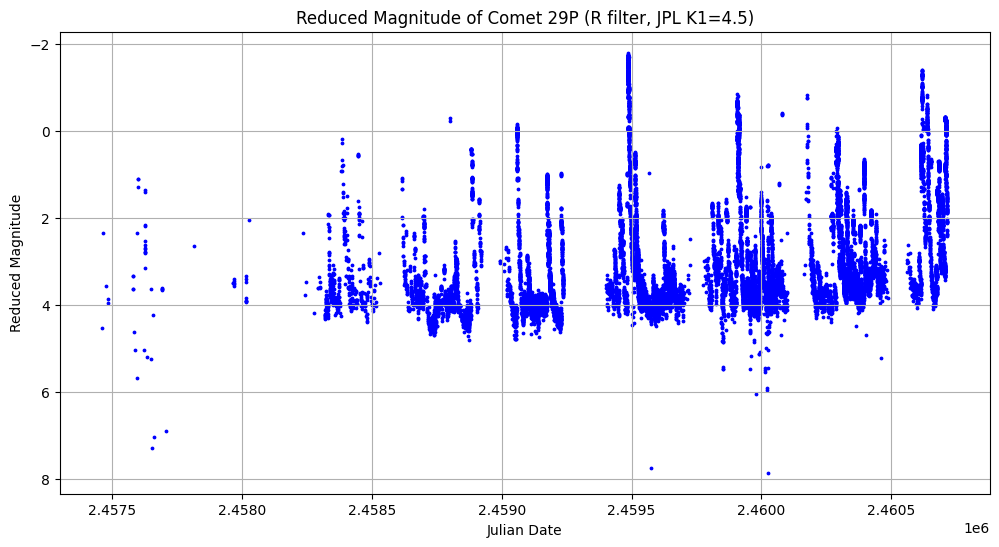

In [11]:
# Calculate reduced magnitudes using a fixed K1 value (JPL recommended K1 = 4.5)

import matplotlib.pyplot as plt

# Load data with ephemerides
file_path = '/content/29P_R_with_ephemerides.csv'
data = pd.read_csv(file_path)

# Extract required columns
magnitudes = data['Magnitude'].values
heliocentric_distances = data['Heliocentric Distance'].values
geocentric_distances = data['Geocentric Distance'].values
phase_angles = data['Phase Angle'].values
julian_dates = data['Julian Date'].values

# Cai's beta value explicitly
beta = 0.035

# Use fixed K1 parameter from JPL
K1 = 4.5

# Calculate reduced magnitudes explicitly
reduced_magnitudes = magnitudes - 2.5 * K1 * np.log10(heliocentric_distances) - 5 * np.log10(geocentric_distances) - phase_angles * beta

# Save results
result_df = pd.DataFrame({
    'Julian Date': julian_dates,
    'Reduced Magnitude': reduced_magnitudes
})
result_df.to_csv('/content/29P_R_final_reduced_magnitudes_JPL_K1.csv', index=False)

# Plot
plt.figure(figsize=(12, 6))
plt.scatter(julian_dates, reduced_magnitudes, s=3, color='blue')
plt.xlabel('Julian Date')
plt.ylabel('Reduced Magnitude')
plt.title('Reduced Magnitude of Comet 29P (R filter, JPL K1=4.5)')
plt.gca().invert_yaxis()
plt.grid()
plt.show()


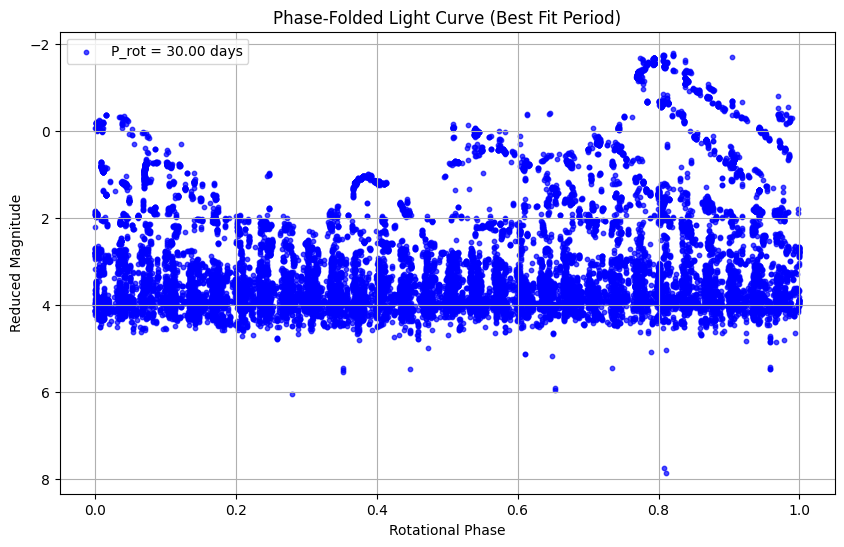

Best-Fit Rotational Period: 30.00 days


In [12]:

from scipy.optimize import minimize

# Load the dataset
file_path = "/content/29P_R_final_reduced_magnitudes_JPL_K1.csv"
data = pd.read_csv(file_path)

# Filter for the valid date range
start_date, end_date = 2458500, 2460449
data = data[(data["Julian Date"] >= start_date) & (data["Julian Date"] <= end_date)].copy()
data = data.sort_values("Julian Date").reset_index(drop=True)

# Define function to compute phase for a given period
def compute_phase(julian_dates, P_rot, t0=None):
    if t0 is None:
        t0 = julian_dates.min()
    return ((julian_dates - t0) / P_rot) % 1  # Normalized between 0 and 1

# Define a function to measure phase dispersion (minimizing phase spread improves alignment)
def phase_dispersion(P_rot, julian_dates, magnitudes):
    phases = compute_phase(julian_dates, P_rot)
    sorted_indices = np.argsort(phases)
    sorted_mags = magnitudes[sorted_indices]
    return np.std(sorted_mags)  # Lower standard deviation = better period fit

# Scan for the best rotational period in range 30-100 days
period_range = np.linspace(30, 100, 70)  # Test 70 periods in this range
best_period = min(period_range, key=lambda P: phase_dispersion(P, data["Julian Date"].values, data["Reduced Magnitude"].values))

# Compute phase for best-fit period
phases = compute_phase(data["Julian Date"].values, best_period)
sorted_indices = np.argsort(phases)
sorted_phases = phases[sorted_indices]
sorted_magnitudes = data["Reduced Magnitude"].values[sorted_indices]

# Plot phase-folded light curve
plt.figure(figsize=(10, 6))
plt.scatter(sorted_phases, sorted_magnitudes, color='blue', s=10, alpha=0.7, label=f'P_rot = {best_period:.2f} days')
plt.xlabel("Rotational Phase")
plt.ylabel("Reduced Magnitude")
plt.title("Phase-Folded Light Curve (Best Fit Period)")
plt.gca().invert_yaxis()
plt.grid(True)
plt.legend()
plt.show()

# Print best rotational period
print(f"Best-Fit Rotational Period: {best_period:.2f} days")


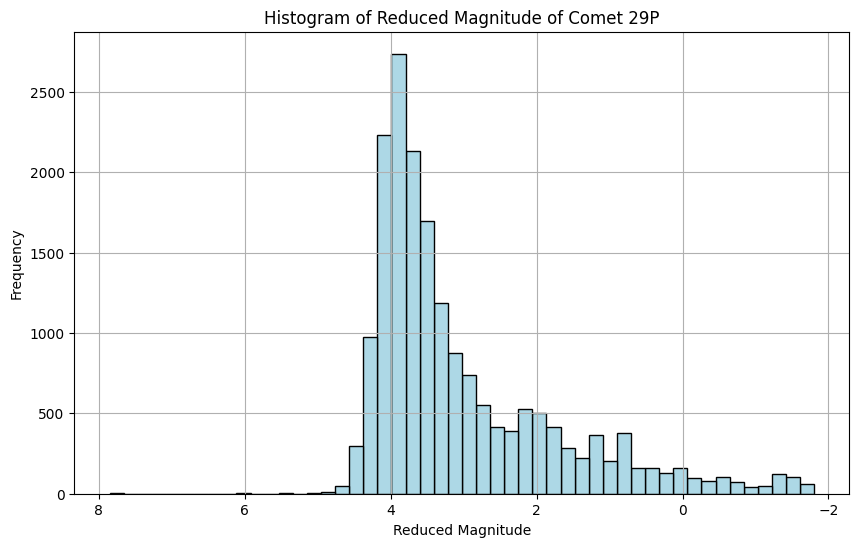

Baseline (Median) Magnitude: 3.52
Analysis with Median Baseline:

Reduced Magnitude with Outbursts (Median Baseline)
Baseline Magnitude: 3.52
Average Events per Year: 6.00
Average Days Between Events: 57.34


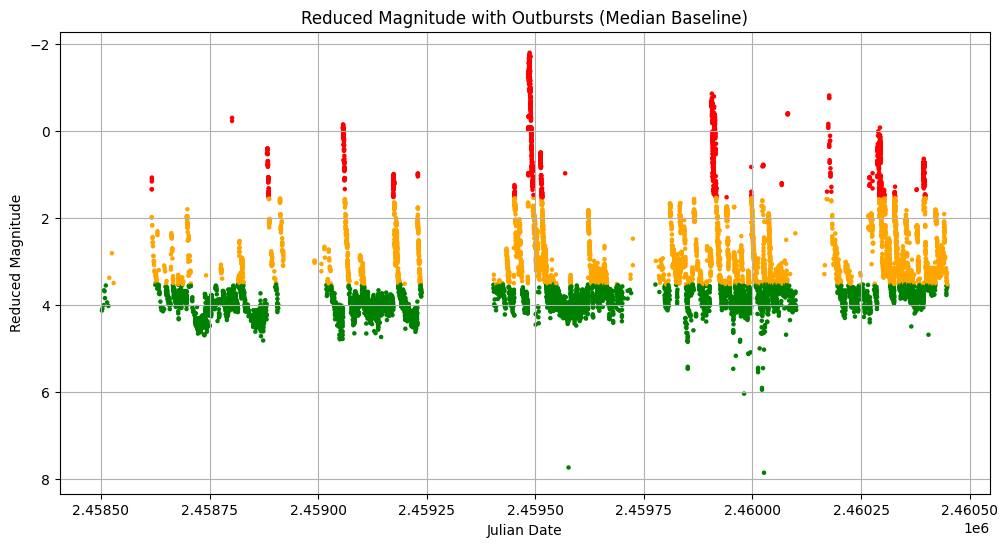

Top 5 Lomb-Scargle Periodogram Peaks:
Period: 25.55 days, Power: 0.6385
Period: 25.62 days, Power: 0.6033
Period: 25.47 days, Power: 0.5350
Period: 55.24 days, Power: 0.5105
Period: 55.58 days, Power: 0.5016


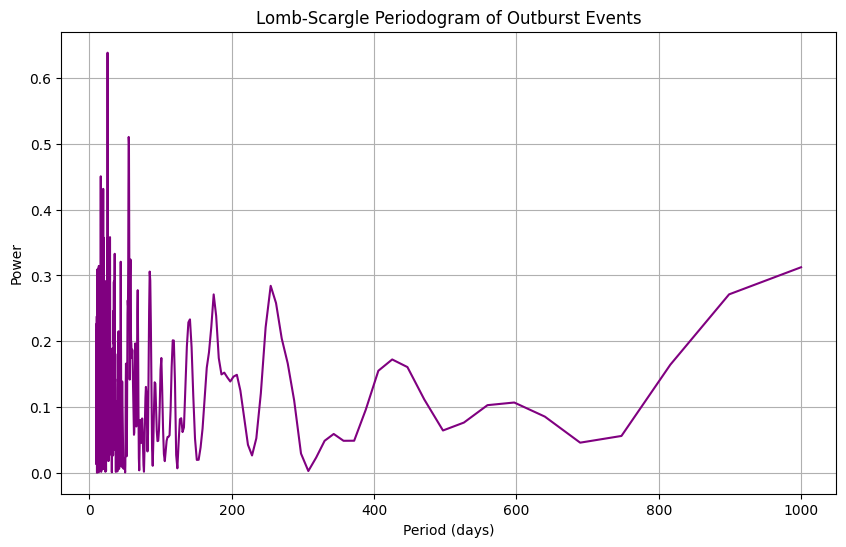

In [13]:
# Revised analytical steps with plot for median baseline


from astropy.timeseries import LombScargle
from scipy.stats import gaussian_kde

# Load data
file_path = '/content/29P_R_final_reduced_magnitudes_JPL_K1.csv'
data = pd.read_csv(file_path)

# Remove dates outside the specified range
filtered_data = data[(data['Julian Date'] >= 2458500) & (data['Julian Date'] <= 2460449)]

# Histogram to identify baseline magnitude
plt.figure(figsize=(10, 6))
plt.hist(filtered_data['Reduced Magnitude'], bins=50, color='lightblue', edgecolor='black')
plt.xlabel('Reduced Magnitude')
plt.ylabel('Frequency')
plt.title('Histogram of Reduced Magnitude of Comet 29P')
plt.grid(True)
plt.gca().invert_xaxis()
plt.show()

# Baseline magnitude (median)
baseline_median = filtered_data['Reduced Magnitude'].median()

print(f"Baseline (Median) Magnitude: {baseline_median:.2f}")

# Function for outburst analysis
def analyze_outbursts(data, baseline, title):
    outburst_threshold = baseline - 2
    data['Outburst'] = data['Reduced Magnitude'] < outburst_threshold

    data['Outburst Event'] = False
    in_outburst = False

    for idx, mag in data.iterrows():
        if mag['Reduced Magnitude'] < outburst_threshold and not in_outburst:
            data.at[idx, 'Outburst Event'] = True
            in_outburst = True
        elif mag['Reduced Magnitude'] >= baseline:
            in_outburst = False

    events = data[data['Outburst Event']]
    years = (data['Julian Date'].max() - data['Julian Date'].min()) / 365.25
    avg_events_per_year = len(events) / years
    avg_days_between_events = np.diff(events['Julian Date']).mean()

    print(f"\n{title}")
    print(f"Baseline Magnitude: {baseline:.2f}")
    print(f"Average Events per Year: {avg_events_per_year:.2f}")
    print(f"Average Days Between Events: {avg_days_between_events:.2f}")

    plt.figure(figsize=(12, 6))
    plt.scatter(data['Julian Date'], data['Reduced Magnitude'], s=5,
                color=np.where(data['Reduced Magnitude'] < outburst_threshold, 'red',
                               np.where(data['Reduced Magnitude'] < baseline, 'orange', 'green')))
    plt.xlabel('Julian Date')
    plt.ylabel('Reduced Magnitude')
    plt.title(title)
    plt.gca().invert_yaxis()
    plt.grid()
    plt.show()

    ls = LombScargle(events['Julian Date'], events['Reduced Magnitude'])
    frequency, power = ls.autopower(minimum_frequency=0.001, maximum_frequency=0.1)
    periods = 1 / frequency

    top_indices = np.argsort(power)[-5:][::-1]
    top_periods = periods[top_indices]
    top_powers = power[top_indices]

    print("Top 5 Lomb-Scargle Periodogram Peaks:")
    for i in range(5):
        print(f"Period: {top_periods[i]:.2f} days, Power: {top_powers[i]:.4f}")

    plt.figure(figsize=(10, 6))
    plt.plot(periods, power, color='purple')
    plt.xlabel('Period (days)')
    plt.ylabel('Power')
    plt.title('Lomb-Scargle Periodogram of Outburst Events')
    plt.grid()
    plt.show()

# Analysis using Median baseline
print("Analysis with Median Baseline:")
analyze_outbursts(filtered_data.copy(), baseline_median, 'Reduced Magnitude with Outbursts (Median Baseline)')




Baseline (Median) Magnitude: 3.52
Analysis with Median Baseline:

Reduced Magnitude with Outbursts (Median Baseline)
Baseline Magnitude: 3.52
Average Events per Year: 6.00
Average Days Between Events: 57.34


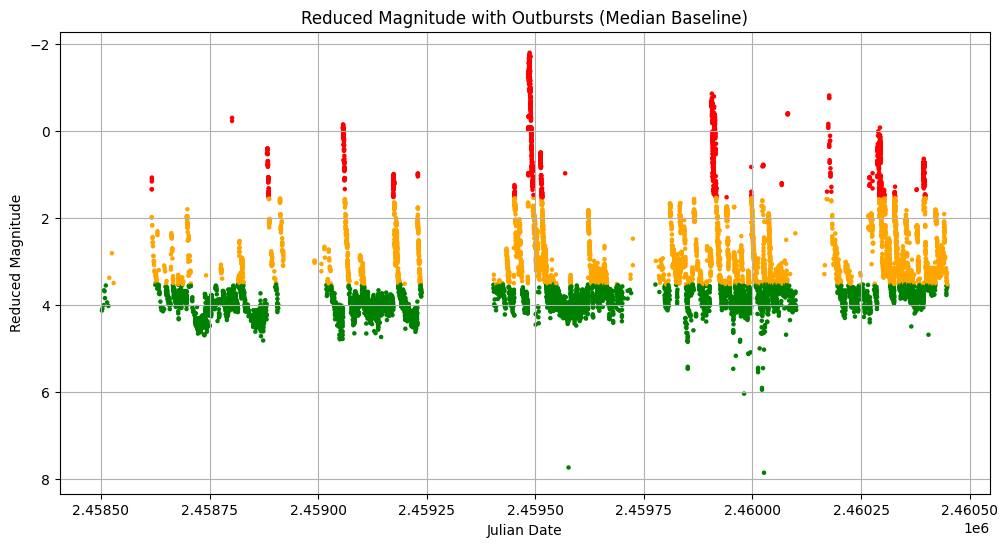

Top 3 Lomb-Scargle Periodogram Peaks:
Period: 55.27 days, Power: 0.5131
Period: 55.62 days, Power: 0.4971
Period: 54.93 days, Power: 0.4462


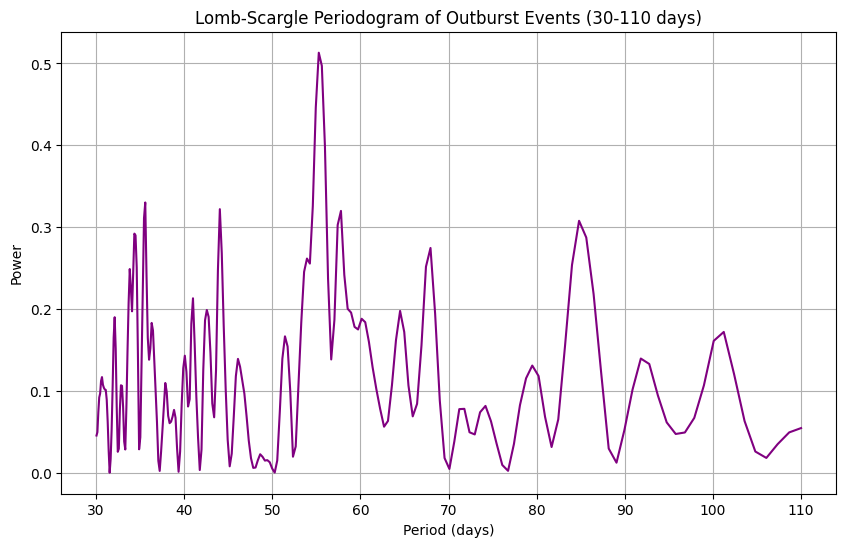

In [14]:
# Revised analytical steps with Lomb-Scargle analysis limited to 30-110 days

# Load data
file_path = '/content/29P_R_final_reduced_magnitudes_JPL_K1.csv'
data = pd.read_csv(file_path)
filtered_data = data[(data['Julian Date'] >= 2458500) & (data['Julian Date'] <= 2460449)]

# Baseline magnitude using median
baseline_median = filtered_data['Reduced Magnitude'].median()

print(f"Baseline (Median) Magnitude: {baseline_median:.2f}")

# Function to identify outbursts and plot results based on given baseline
def analyze_outbursts(data, baseline, title):
    outburst_threshold = baseline - 2
    data['Outburst'] = data['Reduced Magnitude'] < outburst_threshold

    data['Outburst Event'] = False
    in_outburst = False

    for idx in data.index:
        mag = data.at[idx, 'Reduced Magnitude']
        if mag < outburst_threshold and not in_outburst:
            data.at[idx, 'Outburst Event'] = True
            in_outburst = True
        elif mag >= baseline:
            in_outburst = False

    events = data[data['Outburst Event']]
    years = (data['Julian Date'].max() - data['Julian Date'].min()) / 365.25
    avg_events_per_year = len(events) / years
    avg_days_between_events = np.diff(events['Julian Date']).mean()

    print(f"\n{title}")
    print(f"Baseline Magnitude: {baseline:.2f}")
    print(f"Average Events per Year: {avg_events_per_year:.2f}")
    print(f"Average Days Between Events: {avg_days_between_events:.2f}")

    plt.figure(figsize=(12, 6))
    plt.scatter(data['Julian Date'], data['Reduced Magnitude'], s=5,
                color=np.where(data['Reduced Magnitude'] < outburst_threshold, 'red',
                               np.where(data['Reduced Magnitude'] < baseline, 'orange', 'green')))
    plt.xlabel('Julian Date')
    plt.ylabel('Reduced Magnitude')
    plt.title(title)
    plt.gca().invert_yaxis()
    plt.grid()
    plt.show()

    ls = LombScargle(events['Julian Date'], events['Reduced Magnitude'])
    frequency, power = ls.autopower(minimum_frequency=1/110, maximum_frequency=1/30)
    periods = 1 / frequency

    top_indices = np.argsort(power)[-5:][::-1]
    top_periods = periods[top_indices]
    top_powers = power[top_indices]

    print("Top 3 Lomb-Scargle Periodogram Peaks:")
    for i in range(3):
        print(f"Period: {top_periods[i]:.2f} days, Power: {top_powers[i]:.4f}")

    plt.figure(figsize=(10, 6))
    plt.plot(periods, power, color='purple')
    plt.xlabel('Period (days)')
    plt.ylabel('Power')
    plt.title('Lomb-Scargle Periodogram of Outburst Events (30-110 days)')
    plt.grid()
    plt.show()

# Analysis using Median baseline
print("Analysis with Median Baseline:")
analyze_outbursts(filtered_data.copy(), baseline_median, 'Reduced Magnitude with Outbursts (Median Baseline)')



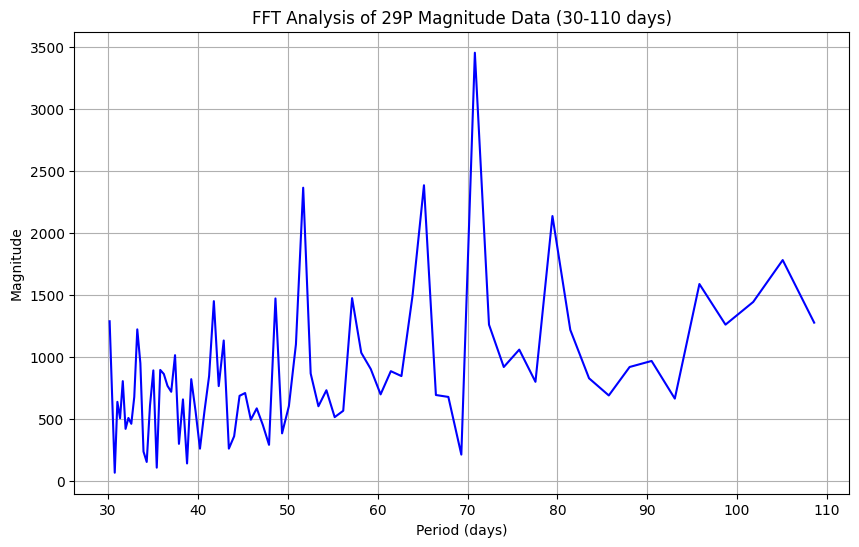

Top 3 FFT Peaks:
Period: 70.81 days, Power: 3454.6380
Period: 51.71 days, Power: 2364.7350
Period: 79.45 days, Power: 2135.8895


In [18]:
# FFT Analysis of 29P Magnitude Data (30-110 days)


from scipy.fftpack import fft, fftfreq
from scipy.signal import find_peaks

# Load the dataset
file_path = '/content/29P_R_final_reduced_magnitudes_JPL_K1.csv'
data = pd.read_csv(file_path)
filtered_data = data[(data['Julian Date'] >= 2458500) & (data['Julian Date'] <= 2460449)]

# Ensure the data is sorted by Julian Date
data = data.sort_values("Julian Date").reset_index(drop=True)

# Compute the time differences to determine an average sampling interval
time_diffs = np.diff(data["Julian Date"])
avg_sampling_interval = np.mean(time_diffs)

# Compute FFT
magnitudes = data["Reduced Magnitude"].values
fft_mag = np.abs(fft(magnitudes))
fft_freq = fftfreq(len(magnitudes), d=avg_sampling_interval)

# Apply frequency filtering to limit FFT period range from 20 to 110 days
pos_mask = (fft_freq > 1/110) & (fft_freq < 1/30)
filtered_fft_freq = fft_freq[pos_mask]
filtered_fft_mag = fft_mag[pos_mask]

# Find top 3 distinct FFT peaks
fft_peaks, _ = find_peaks(filtered_fft_mag, distance=5)
top_fft_indices = np.argsort(filtered_fft_mag[fft_peaks])[-3:][::-1]
top_fft_periods = 1 / filtered_fft_freq[fft_peaks[top_fft_indices]]
top_fft_powers = filtered_fft_mag[fft_peaks[top_fft_indices]]

# Plot FFT spectrum
plt.figure(figsize=(10, 6))
plt.plot(1/filtered_fft_freq, filtered_fft_mag, color='blue')
plt.xlabel("Period (days)")
plt.ylabel("Magnitude")
plt.title("FFT Analysis of 29P Magnitude Data (30-110 days)")
plt.grid(True)
plt.show()

# Print top 3 FFT results
print("Top 3 FFT Peaks:")
for period, power in zip(top_fft_periods, top_fft_powers):
    print(f"Period: {period:.2f} days, Power: {power:.4f}")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 35.4 MB/s eta 0:00:00
Top Detected Periods:
 - Period: 66.32 days (Strength: 4.9676)
 - Period: 52.19 days (Strength: 4.9401)
 - Period: 50.82 days (Strength: 4.9281)


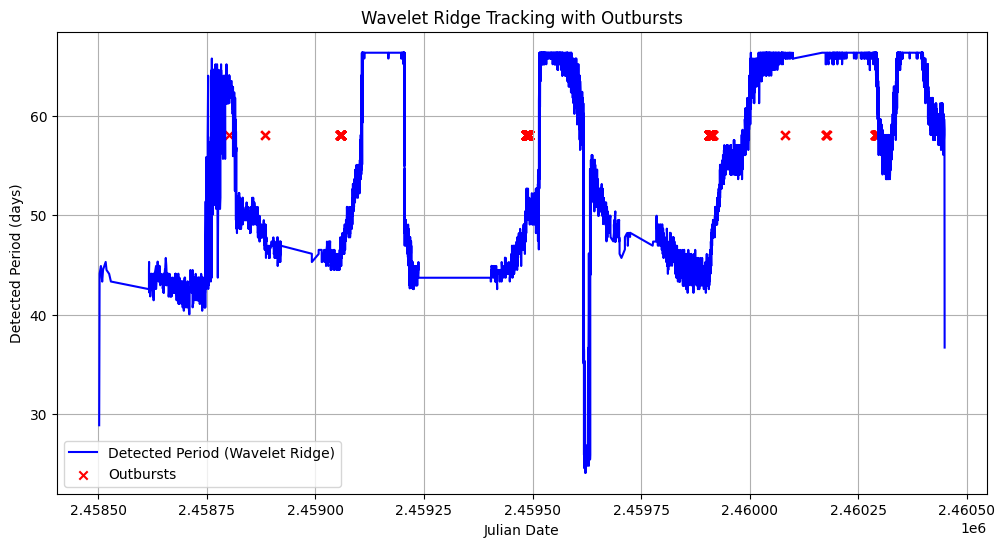

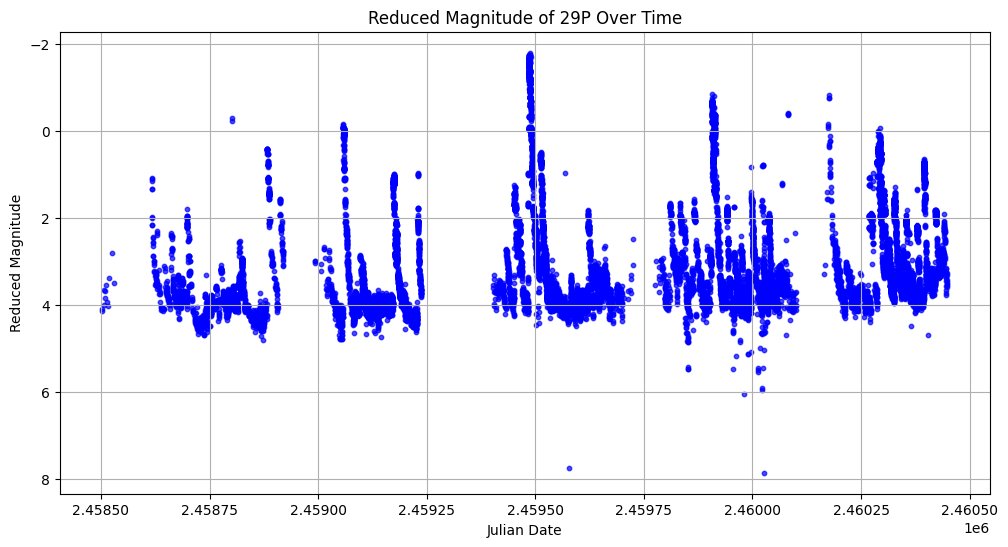

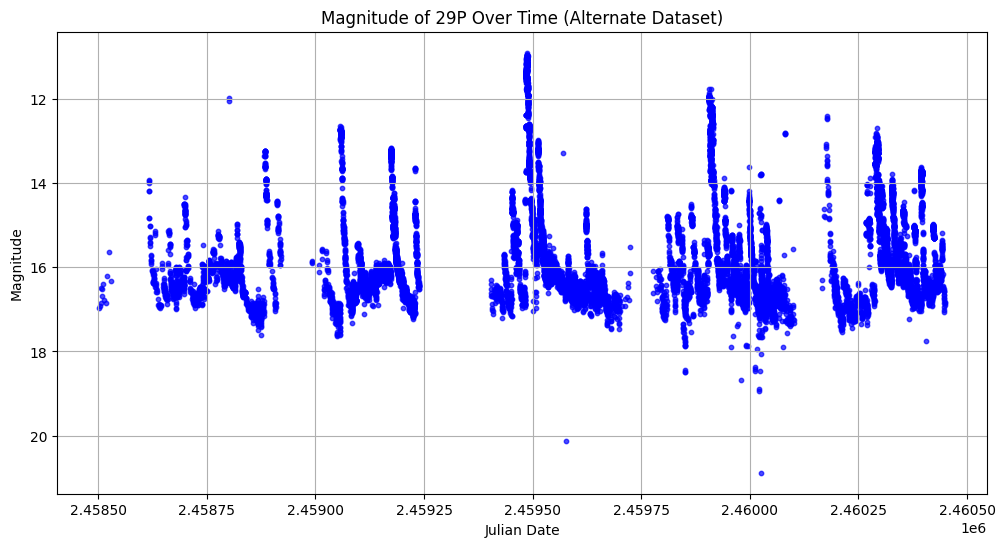

In [19]:
# Ensure PyWavelets is installed
!pip install PyWavelets --quiet

# Import necessary libraries
import pywt
from scipy.signal import find_peaks, periodogram
from scipy.stats import pearsonr  # Correct import

# Load data
file_path = '/content/29P_R_final_reduced_magnitudes_JPL_K1.csv'
data = pd.read_csv(file_path)

# Ensure proper column naming and sorting
data = data.sort_values(by="Julian Date")

# Manually remove dates outside the specified range
data = data[(data['Julian Date'] >= 2458500) & (data['Julian Date'] <= 2460449)]

# Load second dataset with whitespace delimiter and check column names
file_path1 = '/content/29P_R.txt'
data1 = pd.read_csv(file_path1, sep='\t')

# Manually remove dates outside the specified range
data1 = data1[(data1['Julian Date'] >= 2458500) & (data1['Julian Date'] <= 2460449)]


def wavelet_ridge_extraction(julian_dates, magnitudes, scales=np.logspace(0.5, 2.8, num=200)):
    """
    Compute wavelet transform and extract dominant periodicity over time.
    Uses a weighted average of strong peaks for more stability.
    """
    sampling_intervals = np.diff(julian_dates).mean()
    wavelet = 'cmor1.5-1.0'  # Corrected Morlet wavelet
    coefficients, frequencies = pywt.cwt(magnitudes, scales, wavelet, sampling_period=sampling_intervals)

    periods_wavelet = 1 / frequencies  # Convert frequency to period
    ridge_indices = np.argmax(np.abs(coefficients), axis=0)  # Find dominant power ridge
    detected_periods = periods_wavelet[ridge_indices]  # Extract periods
    smoothed_ridge = np.convolve(detected_periods, np.ones(3)/3, mode='same')  # Reduced smoothing window

    # Determine the top 3 detected periods
    mean_power = np.abs(coefficients).mean(axis=1)
    top_period_indices = np.argsort(mean_power)[-5:][::-1]  # Get top 5 strongest peaks
    top_periods = periods_wavelet[top_period_indices]
    top_strengths = mean_power[top_period_indices]

    # Compute a weighted average of top detected periods
    weighted_best_period = np.average(top_periods, weights=top_strengths)

    print("Top Detected Periods:")
    for i in range(3):
        print(f" - Period: {top_periods[i]:.2f} days (Strength: {top_strengths[i]:.4f})")

    return smoothed_ridge, julian_dates, weighted_best_period, top_strengths[0]

# Compute wavelet ridge
detected_periods, time_series, best_period, best_period_strength = wavelet_ridge_extraction(data["Julian Date"], data["Reduced Magnitude"])

# Identify large outbursts (drops in magnitude beyond 2 std deviations)
magnitude_threshold = data["Reduced Magnitude"].mean() - 2 * data["Reduced Magnitude"].std()
outburst_dates = data[data["Reduced Magnitude"] < magnitude_threshold]["Julian Date"].values


# Plot wavelet ridge extraction results
plt.figure(figsize=(12, 6))
plt.plot(time_series, detected_periods, label="Detected Period (Wavelet Ridge)", color="b", linestyle="-")
plt.scatter(outburst_dates, np.full_like(outburst_dates, np.median(detected_periods)), color="r", marker="x", label="Outbursts")
plt.xlabel("Julian Date")
plt.ylabel("Detected Period (days)")
plt.title("Wavelet Ridge Tracking with Outbursts")
plt.legend()
plt.grid(True)
plt.show()

# Plot for magnitude against time (First dataset)
plt.figure(figsize=(12, 6))
plt.scatter(data["Julian Date"], data["Reduced Magnitude"], s=10, alpha=0.7, color='b')
plt.gca().invert_yaxis()  # Lower magnitude means brighter
plt.xlabel("Julian Date")
plt.ylabel("Reduced Magnitude")
plt.title("Reduced Magnitude of 29P Over Time")
plt.grid(True)
plt.show()

# Plot for magnitude against time (Second dataset)
plt.figure(figsize=(12, 6))
plt.scatter(data1["Julian Date"], data1["Magnitude"], s=10, alpha=0.7, color='b')
plt.gca().invert_yaxis()  # Lower magnitude means brighter
plt.xlabel("Julian Date")
plt.ylabel("Magnitude")
plt.title("Magnitude of 29P Over Time (Alternate Dataset)")
plt.grid(True)
plt.show()
